In [2]:
import os
import pandas as pd
import numpy as np
import copy as copy
import seaborn as sns 
import matplotlib.pyplot as plt 
os.chdir('..')
from src.regressions import *
from src.helpers import *
from src.statistical_analysis import *
from src.evaluation_metrics import *
os.chdir('notebooks')
from sklearn.model_selection import train_test_split
from scipy import stats

Reading, converting, adding a one column and separating (test and forecast) the dataset. Setting tolerance level forever to 0.05.

In [3]:
PATH = os.path.join("..","data","Hongkong.csv")
dataset = pd.read_csv(PATH)
x,y = X_y_from_dataset(dataset)
x = oner(x)
xtest,xforecast,ytest,yforecast = split(x,y)
tolerance=0.05

Full model, assuming A1-A6 holds, calculating the Adjusted R squared to see the linearity and if SSE/SST is small.

In [4]:
beta = least_squares(xtest, ytest)
yhat = np.dot(xtest, beta)
adjR2_full = adjusted_R_squared(ytest, yhat, len(xtest[0]))
SSE_full=SSE(ytest,yhat)
SST_full=SST(ytest)
SSE_full/SST_full
adjR2_full

0.998914708462892

A question arises, do we have multicolinearity between some columns of x? Checking correlation and VIF factors

/Users/kilianlock/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kilianlock/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:>

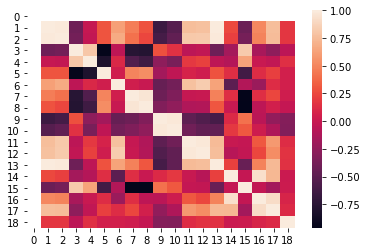

In [5]:
correlation_matrix = np.corrcoef(xtest, rowvar=False)
sns.heatmap(correlation_matrix)

Simple to general Model building

In [6]:
np.diag(np.dot(np.transpose(x),x))

array([4.10000000e+01, 1.60742140e+08, 1.59716725e+05, 1.68661367e+05,
       1.73647264e+05, 3.84924541e+04, 1.78016876e+03, 1.26747522e+03,
       1.36249162e+03, 3.39014419e+04, 2.79781790e+04, 1.13766336e+06,
       1.87168127e+06, 1.03467024e+09, 1.78609307e+05, 6.93421960e+05,
       1.94780425e+05, 2.12910805e+05, 4.12343895e+05])

General to simple
	Check smallest/biggest linearity decay
	Check whether t test says is ok
	Delete this guy

In [9]:
def generaltosimple(x, y, tolerance):
    
    l = np.zeros((len(x[0]),len(x[0])))
    xtemp2 = copy.copy(x)

    for f in range(0,len(x[0])-1):

        for i in range(0, len(x[0])-f):
            xtemp = copy.copy(xtemp2)
            xtemp = np.delete(xtemp, i, axis=1)
            beta = least_squares(xtemp, y)
            l[i,f]=R_squared(y, np.dot(xtemp,beta))

        ind = np.argmax(l[:,f])
        betta = least_squares(xtemp2, y)
        error=SSE(y, np.dot(xtemp2,betta))/(len(x)-len(xtemp2[0]))
        skk=np.diag(np.dot(np.transpose(x),x))
        tstat = np.abs(betta[ind]/np.sqrt(error*skk[ind]))

        degoffree=len(x)-len(x[0])
        tstatvalue=stats.t.ppf(1-tolerance/2, degoffree)


        if ((tstat)>=tstatvalue):
            print(999)

        else:
            xtemp2 = np.delete(xtemp2, ind, axis=1)
            
        return xtemp2

l=generaltosimple(xtest,ytest,0.16)
l

999


array([[1.00000000e+00, 1.96000000e+03, 2.35913484e+01, 7.20206894e+01,
        6.93919134e+01, 2.66728946e+01, 5.71430016e+00, 1.30641600e+00,
        1.61949712e+00, 3.68203116e+01, 2.94296691e+01, 1.04249791e+02,
        1.86785331e+02, 3.06400000e+03, 5.75412892e+01, 3.69915931e+02,
        5.70049847e+01, 4.48536241e+01, 1.00452794e+02],
       [1.00000000e+00, 1.96100000e+03, 2.36123330e+01, 7.37422262e+01,
        7.08925168e+01, 2.49503644e+01, 5.71430016e+00, 1.30740941e+00,
        1.57788491e+00, 3.59760924e+01, 2.88539139e+01, 9.82855703e+01,
        1.73458076e+02, 3.21984000e+03, 5.89124662e+01, 3.60151525e+02,
        5.79708428e+01, 4.50591773e+01, 9.96048154e+01],
       [1.00000000e+00, 1.96200000e+03, 2.44854684e+01, 7.22129616e+01,
        6.89476206e+01, 2.62471816e+01, 5.71430016e+00, 1.53985683e+00,
        1.81680880e+00, 3.78221881e+01, 3.09669449e+01, 9.74239565e+01,
        1.70558181e+02, 3.36056000e+03, 5.87522722e+01, 2.82496611e+02,
        5.71754266e+01

RMSE 

MAE